In [8]:
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPool1D, BatchNormalization, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors

nltk.download('stopwords')
nltk.download('punkt')

# Toujours les mêmes données 
df = pd.read_csv("Restaurant reviews.csv")
df = df.drop(["Restaurant", "Reviewer", "Metadata", "Pictures", "7514"], axis=1)
df['Review'] = df['Review'].fillna("Nothing")
df = df[pd.to_numeric(df['Rating'], errors='coerce').notnull()]
df['Rating'] = df['Rating'].astype(float)
df['target'] = np.where(df["Rating"].astype(float) >= 3, 1, 0)  # Binarisation des labels

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/victorasencio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/victorasencio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


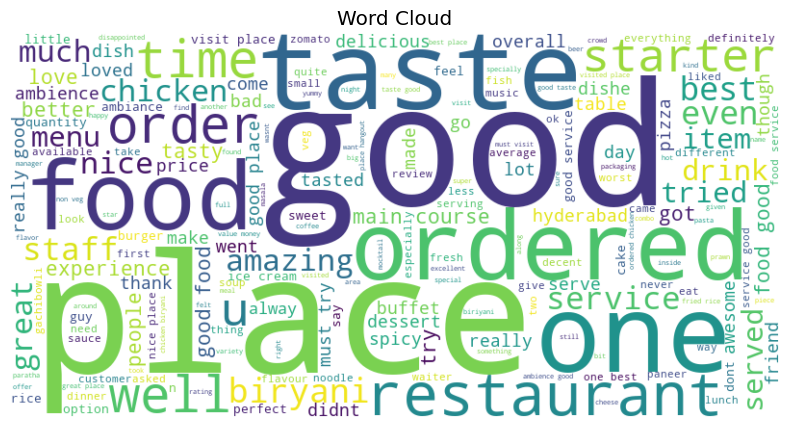

In [ ]:
# Nettoyage du texte
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['Processed_Review'] = df['Review'].apply(preprocess_text)
all_words = ' '.join(df['Processed_Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

In [ ]:
# Cette fois on utilisera word2vec
word2vec_path = 'GoogleNews-vectors-negative300.bin' 
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
embedding_dim = 300

# Tokenisation
vocab_size = 5000  
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Processed_Review'])
sequences = tokenizer.texts_to_sequences(df['Processed_Review'])
max_length = 100
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
y = df['target'].values

# Création de la matrice d'embedding Word2Vec
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        try:
            embedding_vector = word2vec[word]
            embedding_matrix[index] = embedding_vector
        except KeyError:
            # Si le mot n'est pas dans le modèle Word2Vec, il reste à zéro
            pass

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Création du modèle avec les embeddings Word2Vec
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)),
    GlobalMaxPool1D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/Users/victorasencio/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.7691 - loss: 0.5060 - val_accuracy: 0.8731 - val_loss: 0.3785
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.8774 - loss: 0.3043 - val_accuracy: 0.8961 - val_loss: 0.2549
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.8970 - loss: 0.2587 - val_accuracy: 0.8966 - val_loss: 0.2348
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.8958 - loss: 0.2420 - val_accuracy: 0.8916 - val_loss: 0.2344
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.8992 - loss: 0.2354 - val_accuracy: 0.8966 - val_loss: 0.2406
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.9115 - loss: 0.2059 - val_accuracy: 0.8886 - val_loss: 0.2595
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9123 - loss: 0.2106 - val_accuracy: 0.8991 - val_loss: 0.2261
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9149 - loss: 0.2012 - 

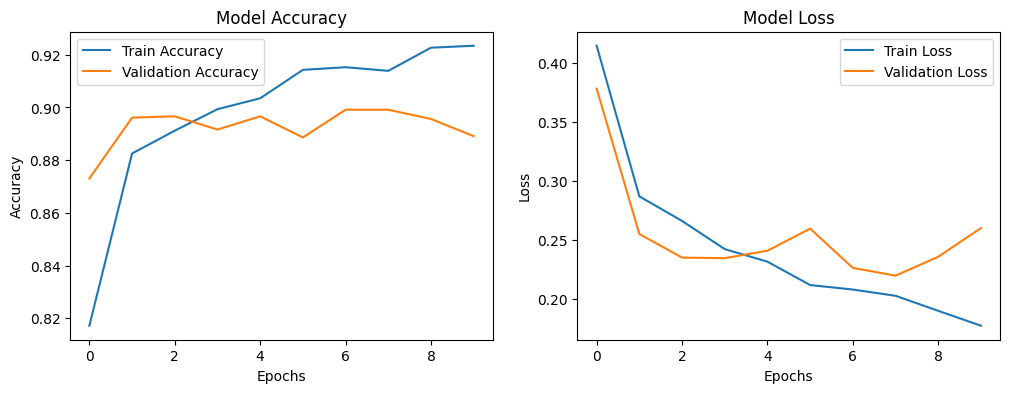

In [ ]:
# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Évaluation
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


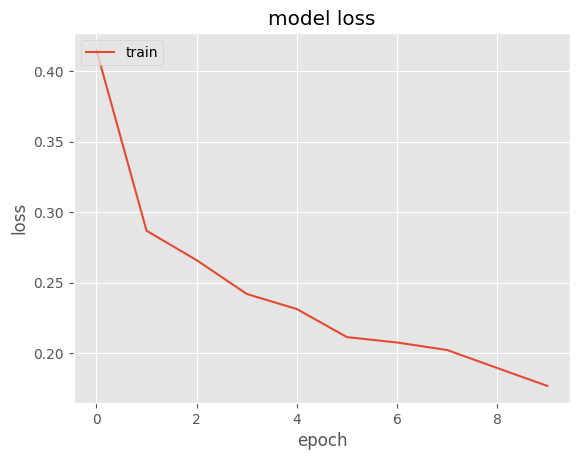

In [7]:
plt.style.use('ggplot')
%matplotlib inline

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()